# Imports

In [1]:
import pandas
import numpy
import pickle

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

SEED=0

# Load Data

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/QMIND_2023-2024/'
file_names = {2015: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015_20240223.csv',
              2016: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20240223.csv',
              2017: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017_20240223.csv',
              2018: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2018_20240223.csv',
              2019: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2019_20240203.csv'
             }

columns_to_keep = ['Age Group', 'Gender', 'Race', 'Ethnicity', 'Length of Stay',
                   'Type of Admission', 'APR MDC Description', 'APR Severity of Illness Description',
                   'APR Risk of Mortality', 'APR Medical Surgical Description']

df = []
for year, file_name in file_names.items():
    # Load data and only keep relevant columns
    df_temp = pandas.read_csv(path + file_name, low_memory=False)[columns_to_keep]

    # Drop rows with NA/NULL values
    df_temp = df_temp.dropna().reset_index(drop=True)

    # Drop rows with infrequent or unknown values
    df_temp = df_temp[df_temp['Gender'] != 'U']
    df_temp = df_temp[df_temp['Type of Admission'] != 'Not Available']
    df_temp = df_temp[df_temp['APR Medical Surgical Description'] != 'Not Applicable']
    df_temp = df_temp[~df_temp['APR MDC Description'].isin(['PRE MDC', 'Pre-MDC or Ungroupable'])]

    # Drop duplicate rows
    df_temp = df_temp.drop_duplicates(ignore_index=True)

    # Remove rows with length of stay of "120 +"
    df_temp = df_temp[df_temp['Length of Stay'] != '120 +']
    df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)

    df.append(df_temp)
    del(df_temp)

df = pandas.concat(df, ignore_index=True)

# Drop duplicate rows
df = df.drop_duplicates(ignore_index=True)

display(df)

<ipython-input-2-8e4d2f220cb1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)


,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description
0,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Diseases and Disorders of the Respiratory System,Moderate,Minor,Medical
1,70 or Older,F,White,Not Span/Hispanic,4,Elective,"Endocrine, Nutritional and Metabolic Diseases ...",Moderate,Moderate,Medical
2,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Diseases and Disorders of the Respiratory System,Minor,Minor,Medical
3,50 to 69,F,White,Not Span/Hispanic,2,Elective,Diseases and Disorders of the Digestive System,Moderate,Minor,Medical
4,70 or Older,M,White,Not Span/Hispanic,2,Elective,Diseases and Disorders of the Respiratory System,Minor,Moderate,Medical
...,...,...,...,...,...,...,...,...,...,...
1015727,70 or Older,M,White,Not Span/Hispanic,28,Urgent,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,Minor,Minor,Surgical
1015728,18 to 29,M,Black/African American,Not Span/Hispanic,7,Urgent,"INJURIES, POISONINGS AND TOXIC EFFECTS OF DRUGS",Moderate,Minor,Medical
1015729,70 or Older,F,White,Not Span/Hispanic,12,Urgent,DISEASES AND DISORDERS OF THE MUSCULOSKELETAL ...,Moderate,Minor,Surgical
1015730,50 to 69,M,Other Race,Not Span/Hispanic,5,Urgent,INFECTIOUS AND PARASITIC DISEASES (SYSTEMIC OR...,Moderate,Moderate,Medical


# Data Exploration

In [3]:
# Fix inconsistencies in description column
df['APR MDC Description'] = df['APR MDC Description'].str.lower()
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'infectious and parasitic diseases, systemic or unspecified sites',
                                        'infectious and parasitic diseases (systemic or unspecified sites)', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'factors influencing health status and other contacts with health services',
                                        'rehabilitation, aftercare, other factors influencing health status and other health service contacts', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the musculoskeletal system and conn tissue',
                                        'diseases and disorders of the musculoskeletal system and connective tissue', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the ear, nose, mouth and throat',
                                        'ear, nose, mouth, throat and craniofacial diseases and disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of blood, blood forming organs and immunological disorders',
                                        'diseases and disorders of the blood and blood forming organs and immunological disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'injuries, poisonings and toxic effects of drugs',
                                        'poisonings, toxic effects, other injuries and other complications of treatment', df['APR MDC Description'])

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015732 entries, 0 to 1015731
Data columns (total 10 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   Age Group                            1015732 non-null  object
 1   Gender                               1015732 non-null  object
 2   Race                                 1015732 non-null  object
 3   Ethnicity                            1015732 non-null  object
 4   Length of Stay                       1015732 non-null  int64 
 5   Type of Admission                    1015732 non-null  object
 6   APR MDC Description                  1015732 non-null  object
 7   APR Severity of Illness Description  1015732 non-null  object
 8   APR Risk of Mortality                1015732 non-null  object
 9   APR Medical Surgical Description     1015732 non-null  object
dtypes: int64(1), object(9)
memory usage: 77.5+ MB


In [5]:
df.describe(include='all')

,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description
count,1015732,1015732,1015732,1015732,1.015732e+06,1015732,1015732,1015732,1015732,1015732
unique,5,2,4,4,NaN,5,26,4,4,2
top,50 to 69,M,White,Not Span/Hispanic,NaN,Emergency,diseases and disorders of the circulatory system,Major,Minor,Medical
freq,314860,515669,391471,629786,NaN,590606,95464,352053,344131,639806
mean,NaN,NaN,NaN,NaN,1.384406e+01,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.628915e+01,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,8.000000e+00,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.700000e+01,NaN,NaN,NaN,NaN,NaN


In [6]:
for column in df.columns:
    print(column)
    print(df[column].value_counts(dropna=False))
    print()

Age Group
50 to 69       314860
70 or Older    267572
30 to 49       205509
0 to 17        117204
18 to 29       110587
Name: Age Group, dtype: int64

Gender
M    515669
F    500063
Name: Gender, dtype: int64

Race
White                     391471
Other Race                334058
Black/African American    235228
Multi-racial               54975
Name: Race, dtype: int64

Ethnicity
Not Span/Hispanic    629786
Spanish/Hispanic     215374
Unknown              144247
Multi-ethnic          26325
Name: Ethnicity, dtype: int64

Length of Stay
2      77830
1      77504
3      75852
4      70301
5      63321
       ...  
114      196
117      190
118      185
116      176
115      170
Name: Length of Stay, Length: 119, dtype: int64

Type of Admission
Emergency    590606
Elective     212104
Urgent       170407
Trauma        24509
Newborn       18106
Name: Type of Admission, dtype: int64

APR MDC Description
diseases and disorders of the circulatory system                                          

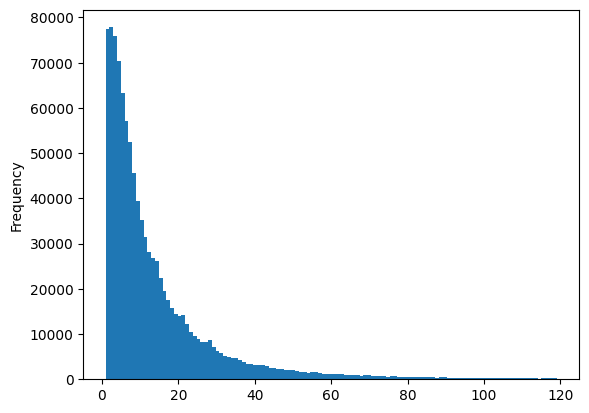

In [7]:
# Plot length of stay
df[df['Length of Stay'] != '120 +']['Length of Stay'].astype(int).plot.hist(bins=119);

# Data Preparation/Processing

In [8]:
# Combine length of stay into multi-class categories (v1)
target_classes_multiclass_v1 = ['1-4 days', '5-9 days', '10-119 days']
lim_1 = 5
lim_2 = 10
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'].value_counts()

3    456101
1    301487
2    258144
Name: Length of Stay - Multi-class v1, dtype: int64

In [9]:
# Combine length of stay into multi-class categories (v2)
target_classes_multiclass_v2 = ['1-6 days', '7-14 days', '15-119 days']
lim_1 = 7
lim_2 = 15
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'].value_counts()

1    421909
3    308380
2    285443
Name: Length of Stay - Multi-class v2, dtype: int64

In [10]:
# Combine length of stay into binary categories (v1)
target_classes_binary_v1 = ['1-7 days', '8-119 days']
lim = 8
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay - Binary v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v1'])
df['Length of Stay - Binary v1'].value_counts()

1    541268
0    474464
Name: Length of Stay - Binary v1, dtype: int64

In [11]:
# Combine length of stay into binary categories (v2)
target_classes_binary_v2 = ['1-9 days', '10-119 days']
lim = 10
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay - Binary v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v2'])
df['Length of Stay - Binary v2'].value_counts()

0    559631
1    456101
Name: Length of Stay - Binary v2, dtype: int64

In [12]:
# Combine length of stay into binary categories (v3)
target_classes_binary_v3 = ['1-10 days', '11-119 days']
lim = 11
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay - Binary v3'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v3'])
df['Length of Stay - Binary v3'].value_counts()

0    594795
1    420937
Name: Length of Stay - Binary v3, dtype: int64

In [13]:
# Split into training and testing subsets
X = df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3'])
y_multiclass_v1 = df['Length of Stay - Multi-class v1']
y_multiclass_v2 = df['Length of Stay - Multi-class v2']
y_binary_v1 = df['Length of Stay - Binary v1']
y_binary_v2 = df['Length of Stay - Binary v2']
y_binary_v3 = df['Length of Stay - Binary v3']
y_regression = df['Length of Stay']
X_train, X_test, y_multiclass_v1_train, y_multiclass_v1_test, y_multiclass_v2_train, y_multiclass_v2_test, y_binary_v1_train, y_binary_v1_test, y_binary_v2_train, y_binary_v2_test, y_binary_v3_train, y_binary_v3_test, y_regression_train, y_regression_test = train_test_split(X, y_multiclass_v1, y_multiclass_v2, y_binary_v1, y_binary_v2, y_binary_v3, y_regression, test_size=0.2, random_state=SEED, stratify=y_regression)
print('Training:', len(X_train))
print('Testing:', len(X_test))

Training: 812585
Testing: 203147


In [14]:
# One-hot encode categorical features

for column in X_train.columns:
    for value in numpy.unique(df[column]):
        X_train[column + ' - ' + value] = numpy.where(X_train[column] == value, 1, 0)
        X_test[column + ' - ' + value] = numpy.where(X_test[column] == value, 1, 0)

# Drop original columns
X_train = X_train.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)
X_test = X_test.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)

# Print number of columns after one-hot encoding
print('Number of columns after one-hot encoding:', X_train.shape[1])

Number of columns after one-hot encoding: 56


# Training and Testing Functions

In [15]:
def train_and_test_classification(y_train, y_test, mode, target_names):
    models = {'BernoulliNB': BernoulliNB(), 'LogisticRegression': LogisticRegression(max_iter=500, random_state=SEED),
              'MLPClassifier': MLPClassifier(max_iter=500, random_state=SEED), 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
              'RandomForestClassifier': RandomForestClassifier(random_state=SEED)
              }

    for model_name, model in models.items():
        print(model_name)

        # Training
        model = model.fit(X_train, y_train)

        # Testing
        classifications = model.predict(X_test)
        probabilities = model.predict_proba(X_test)

        # Evaluation
        print(confusion_matrix(y_test, classifications))
        print()
        print(classification_report(y_test, classifications, target_names=target_names))
        print('Accuracy: ', round(accuracy_score(y_test, classifications), 4))
        if mode == 'Multi-Class':
            print('Recall:   ', round(recall_score(y_test, classifications, average='macro'), 4))
            print('Precision:', round(precision_score(y_test, classifications, average='macro'), 4))
            print('F1:       ', round(f1_score(y_test, classifications, average='macro'), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities, multi_class='ovr'), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities), 4))
        elif mode == 'Binary':
            print('Recall:   ', round(recall_score(y_test, classifications), 4))
            print('Precision:', round(precision_score(y_test, classifications), 4))
            print('F1:       ', round(f1_score(y_test, classifications), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities[:,1]), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities[:,1]), 4))
        print('MCC:      ', round(matthews_corrcoef(y_test, classifications), 4))

        print()

    return models

In [23]:
def train_and_test_regression(y_train, y_test):
    models = {'LinearRegression': LinearRegression(), 'MLPRegressor': MLPRegressor(max_iter=500, random_state=SEED),
              'DecisionTreeRegressor': DecisionTreeRegressor(random_state=SEED), 'RandomForestRegressor': RandomForestRegressor(random_state=SEED)}

    for model_name, model in models.items():
        print(model_name)

        # To ensure positive: https://stackoverflow.com/questions/26897981/restrict-the-predictions-from-sgdregressor-in-scikit-learn-to-positive-values

        # Training
        model = model.fit(X_train, numpy.log(y_train))

        # Testing
        predictions = numpy.round(numpy.exp(model.predict(X_test)))

        # Evaluation (regression)
        print('R2:                         ', round(r2_score(y_test, predictions), 4))
        print('Mean absolute error:        ', round(mean_absolute_error(y_test, predictions), 4))
        print('Median absolute error:      ', round(median_absolute_error(y_test, predictions), 4))
        print('Mean squared error:         ', round(mean_squared_error(y_test, predictions), 4))
        print('Root mean squared error:    ', round(mean_squared_error(y_test, predictions, squared=False), 4))
        print('Mean squared log error:     ', round(mean_squared_log_error(y_test, predictions), 4))
        print('Root mean squared log error:', round(mean_squared_log_error(y_test, predictions, squared=False), 4))

        # Evaluation (classification)
        print('Accuracy:                   ', round(accuracy_score(y_test, predictions), 4))
        print('Recall:                     ', round(recall_score(y_test, predictions, average='macro'), 4))
        print('Precision:                  ', round(precision_score(y_test, predictions, average='macro'), 4))
        print('F1:                         ', round(f1_score(y_test, predictions, average='macro'), 4))
        print('MCC:                        ', round(matthews_corrcoef(y_test, predictions), 4))

        print()

    return models

# Training and Testing (Multiclass)

In [17]:
models_multiclass_v1 = train_and_test_classification(y_multiclass_v1_train, y_multiclass_v1_test, 'Multi-Class', target_classes_multiclass_v1)

BernoulliNB
[[36649  3575 20073]
 [23096  4047 24486]
 [21257  4320 65644]]

              precision    recall  f1-score   support

    1-4 days       0.45      0.61      0.52     60297
    5-9 days       0.34      0.08      0.13     51629
 10-119 days       0.60      0.72      0.65     91221

    accuracy                           0.52    203147
   macro avg       0.46      0.47      0.43    203147
weighted avg       0.49      0.52      0.48    203147

Accuracy:  0.5235
Recall:    0.4686
Precision: 0.4623
F1:        0.4326
AU_ROC:    0.6735
Log loss:  1.0238
MCC:       0.2475

LogisticRegression
[[35594   407 24296]
 [21467   492 29670]
 [14823   411 75987]]

              precision    recall  f1-score   support

    1-4 days       0.50      0.59      0.54     60297
    5-9 days       0.38      0.01      0.02     51629
 10-119 days       0.58      0.83      0.69     91221

    accuracy                           0.55    203147
   macro avg       0.49      0.48      0.41    203147
weigh

In [18]:
models_multiclass_v2 = train_and_test_classification(y_multiclass_v2_train, y_multiclass_v2_test, 'Multi-Class', target_classes_multiclass_v2)

BernoulliNB
[[59542  9393 15446]
 [29283  9658 18149]
 [18381  8348 34947]]

              precision    recall  f1-score   support

    1-6 days       0.56      0.71      0.62     84381
   7-14 days       0.35      0.17      0.23     57090
 15-119 days       0.51      0.57      0.54     61676

    accuracy                           0.51    203147
   macro avg       0.47      0.48      0.46    203147
weighted avg       0.48      0.51      0.49    203147

Accuracy:  0.5127
Recall:    0.4805
Precision: 0.4726
F1:        0.4623
AU_ROC:    0.6792
Log loss:  1.0323
MCC:       0.2462

LogisticRegression
[[65055  3575 15751]
 [33594  4173 19323]
 [18717  4264 38695]]

              precision    recall  f1-score   support

    1-6 days       0.55      0.77      0.64     84381
   7-14 days       0.35      0.07      0.12     57090
 15-119 days       0.52      0.63      0.57     61676

    accuracy                           0.53    203147
   macro avg       0.48      0.49      0.45    203147
weigh

# Training and Testing (Binary)

In [19]:
models_binary_v1 = train_and_test_classification(y_binary_v1_train, y_binary_v1_test, 'Binary', target_classes_binary_v1)

BernoulliNB
[[62064 32828]
 [36415 71840]]

              precision    recall  f1-score   support

    1-7 days       0.63      0.65      0.64     94892
  8-119 days       0.69      0.66      0.67    108255

    accuracy                           0.66    203147
   macro avg       0.66      0.66      0.66    203147
weighted avg       0.66      0.66      0.66    203147

Accuracy:  0.6591
Recall:    0.6636
Precision: 0.6864
F1:        0.6748
AU_ROC:    0.7215
Log loss:  0.6552
MCC:       0.3171

LogisticRegression
[[59835 35057]
 [29180 79075]]

              precision    recall  f1-score   support

    1-7 days       0.67      0.63      0.65     94892
  8-119 days       0.69      0.73      0.71    108255

    accuracy                           0.68    203147
   macro avg       0.68      0.68      0.68    203147
weighted avg       0.68      0.68      0.68    203147

Accuracy:  0.6838
Recall:    0.7305
Precision: 0.6928
F1:        0.7111
AU_ROC:    0.7457
Log loss:  0.5931
MCC:       0.363

In [20]:
models_binary_v2 = train_and_test_classification(y_binary_v2_train, y_binary_v2_test, 'Binary', target_classes_binary_v2)

BernoulliNB
[[81189 30737]
 [36937 54284]]

              precision    recall  f1-score   support

    1-9 days       0.69      0.73      0.71    111926
 10-119 days       0.64      0.60      0.62     91221

    accuracy                           0.67    203147
   macro avg       0.66      0.66      0.66    203147
weighted avg       0.67      0.67      0.67    203147

Accuracy:  0.6669
Recall:    0.5951
Precision: 0.6385
F1:        0.616
AU_ROC:    0.727
Log loss:  0.6493
MCC:       0.3231

LogisticRegression
[[83615 28311]
 [35608 55613]]

              precision    recall  f1-score   support

    1-9 days       0.70      0.75      0.72    111926
 10-119 days       0.66      0.61      0.64     91221

    accuracy                           0.69    203147
   macro avg       0.68      0.68      0.68    203147
weighted avg       0.68      0.69      0.68    203147

Accuracy:  0.6854
Recall:    0.6097
Precision: 0.6627
F1:        0.6351
AU_ROC:    0.752
Log loss:  0.5861
MCC:       0.3603



In [21]:
models_binary_v3 = train_and_test_classification(y_binary_v3_train, y_binary_v3_test, 'Binary', target_classes_binary_v3)

BernoulliNB
[[89335 29624]
 [36592 47596]]

              precision    recall  f1-score   support

   1-10 days       0.71      0.75      0.73    118959
 11-119 days       0.62      0.57      0.59     84188

    accuracy                           0.67    203147
   macro avg       0.66      0.66      0.66    203147
weighted avg       0.67      0.67      0.67    203147

Accuracy:  0.674
Recall:    0.5654
Precision: 0.6164
F1:        0.5898
AU_ROC:    0.7295
Log loss:  0.6395
MCC:       0.321

LogisticRegression
[[93759 25200]
 [37644 46544]]

              precision    recall  f1-score   support

   1-10 days       0.71      0.79      0.75    118959
 11-119 days       0.65      0.55      0.60     84188

    accuracy                           0.69    203147
   macro avg       0.68      0.67      0.67    203147
weighted avg       0.69      0.69      0.69    203147

Accuracy:  0.6906
Recall:    0.5529
Precision: 0.6488
F1:        0.597
AU_ROC:    0.7548
Log loss:  0.5764
MCC:       0.3515



# Training and Testing (Regression)

In [24]:
models_regression = train_and_test_regression(y_regression_train, y_regression_test)

LinearRegression
R2:                          0.1211
Mean absolute error:         8.6835
Median absolute error:       4.0
Mean squared error:          233.0934
Root mean squared error:     15.2674
Mean squared log error:      0.6366
Root mean squared log error: 0.7979
Accuracy:                    0.0631
Recall:                      0.0115
Precision:                   0.0161


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:                          0.0101
MCC:                         0.0199

MLPRegressor
R2:                          0.228
Mean absolute error:         8.1069
Median absolute error:       4.0
Mean squared error:          204.7543
Root mean squared error:     14.3092
Mean squared log error:      0.5568
Root mean squared log error: 0.7462
Accuracy:                    0.0719
Recall:                      0.013
Precision:                   0.0169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:                          0.0119
MCC:                         0.029

DecisionTreeRegressor
R2:                          0.198
Mean absolute error:         8.4578
Median absolute error:       5.0
Mean squared error:          212.7038
Root mean squared error:     14.5844
Mean squared log error:      0.6302
Root mean squared log error: 0.7939
Accuracy:                    0.0671
Recall:                      0.0127
Precision:                   0.0186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:                          0.0123
MCC:                         0.0246

RandomForestRegressor
R2:                          0.2191
Mean absolute error:         8.3306
Median absolute error:       4.0
Mean squared error:          207.1068
Root mean squared error:     14.3912
Mean squared log error:      0.6082
Root mean squared log error: 0.7799
Accuracy:                    0.068
Recall:                      0.0129
Precision:                   0.0164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:                          0.0123
MCC:                         0.0254



# Best models

In [25]:
print(target_classes_multiclass_v2) # ['1-6 days', '7-14 days', '15-119 days']
model_multiclass = models_multiclass_v2['MLPClassifier']

print(target_classes_binary_v3) # ['1-10 days', '11-119 days']
model_binary = models_binary_v3['MLPClassifier']

model_regression = models_regression['MLPRegressor']

pickle.dump(model_multiclass, open(path + 'model_multiclass.sav', 'wb'))
pickle.dump(model_binary, open(path + 'model_binary.sav', 'wb'))
pickle.dump(model_regression, open(path + 'model_regression.sav', 'wb'))

['1-6 days', '7-14 days', '15-119 days']
['1-10 days', '11-119 days']
